# Analysis of Custom-KinFragLib 

## Aim of this notebook

Plotting results of Custom-KinFragLib for the paper. 

## Table of contents

1. Library sizes

    1.1 Pre-filter KinFragLib vs CustomKinFragLib library size

    1.2 Number of fragments after each filtering step 

2. Fragment space 

    2.1 t-SNE plot
    
    2.2 Clustering coverage 

    2.3 Average Tanimoto similarity 

## Imports and preprocessing

In [2]:
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, MACCSkeys
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np 
from collections import Counter
import math

from kinfraglib import filters, utils

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

### Define global paths

In [5]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / "../../data"

In [25]:
fragment_library_original = utils.read_fragment_library(PATH_DATA / "fragment_library")
fragment_library = filters.prefilters.pre_filters(fragment_library_original)


In [26]:
fragment_library_original.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'])

In [8]:
fragment_library_custom = utils.read_fragment_library(PATH_DATA / "fragment_library_custom_filtered")

### 1. Library sizes
#### 1.1 Pre-filtered vs custom library size

In [9]:
SUBPOCKET_COLORS = {
    "AP": "purple",
    "FP": "forestgreen",
    "SE": "c",
    "GA": "tab:orange",
    "B1": "tab:blue",
    "B2": "darkslateblue",
}

def plot_n_fragments_per_subpocket(
    n_fragments_per_subpocket, n_fragments_per_subpocket_custom
):
    """
    Plot number of fragments and deduplicated fragments per subpocket.
    """
    plt.figure(figsize=(8, 8))
    ax1 = plt.bar(
        SUBPOCKET_COLORS.keys(),
        n_fragments_per_subpocket,
        fill=False,
        edgecolor=SUBPOCKET_COLORS.values(),
    )
    ax2 = plt.bar(
        SUBPOCKET_COLORS.keys(),
        n_fragments_per_subpocket_custom,
        color=SUBPOCKET_COLORS.values(),
    )
    plt.legend(["KinFragLib\nfragments", "Custom-KinFragLib\nfragments"], fontsize=17)
    plt.ylabel("# Fragments", fontsize=17)
    plt.xlabel("Subpocket", fontsize=17)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    # Add absolute numbers of custom-kinfraglib fragments on top 
    bars = ax2.patches

    for bar, label in zip(bars, n_fragments_per_subpocket_custom):

        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            label,
            ha="center",
            va="bottom",
            fontsize=17,
            color="black",
        )

    plt.savefig(f"figures/n_fragments_per_subpocket.png", dpi=300, bbox_inches="tight")

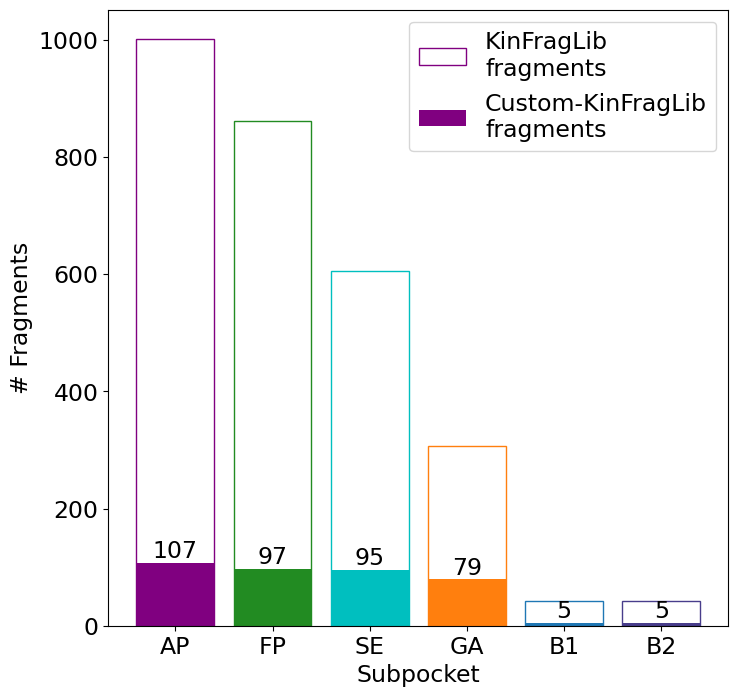

In [9]:
n_fragments_per_subpocket_prefiltered = [len(fragments.drop_duplicates('smiles')) for _, fragments in fragment_library.items()]
n_fragments_per_subpocket_custom = [len(fragments) for _, fragments in fragment_library_custom.items()]
plot_n_fragments_per_subpocket(n_fragments_per_subpocket_prefiltered, n_fragments_per_subpocket_custom)

#### 1.2 Number of fragments after each filtering step 

In [10]:
PATH_DATA_CUSTOM = PATH_DATA / "fragment_library_custom_filtered"
filter_results = pd.read_csv(PATH_DATA_CUSTOM / "custom_filter_results.csv")

In [11]:
def num_frags_development(filter_res):
    """
    Count the number of fragments passing each custom filter step

    ----------
    filter_res : dataframe
        Contains the calculated values and the boolean for each filtering step if a fragment was
        accepted or not.

    Returns
    ---------
    dataframe
        with the number of fragments per subpocket for each filtering step

    """
    # get the column names
    frag_keys = filter_res.keys()
    frag_keys.to_list()
    # keep only the boolean column names (we do not need the computed values here)
    bool_keys = [x for x in frag_keys if "bool" in x and "retro" not in x]
    # create a dataframe to store the number of fragments left after each filtering step
    update_results = pd.DataFrame(0, index=SUBPOCKET_COLORS.keys(), columns=[k[5:] for k in bool_keys])
    # go through all boolean columns and count the number of fragments passing
    for bool_key in bool_keys:
        filter_res_temp = filter_res.loc[filter_res[bool_key] == 0]
        update_results[bool_key[5:]] = filter_res_temp.reset_index().groupby("subpocket", sort=False).size()

    # create a bar plot showing the numbers of fragments passing
    ax = update_results.plot.bar(width=0.9)
    fig = ax.get_figure()

    fig.set_figheight(7)
    fig.set_figwidth(13)

    ax.set_xlabel("Subpocket")
    ax.set_ylabel("Number of fragments")
    ax.set_title("Number of fragments removed in each filtering step")
    plt.savefig(f"figures/n_fragments_filter_step.png", dpi=300, bbox_inches="tight")
    plt.show()
    # return dataframe with number of fragments after each filtering step.
    return update_results

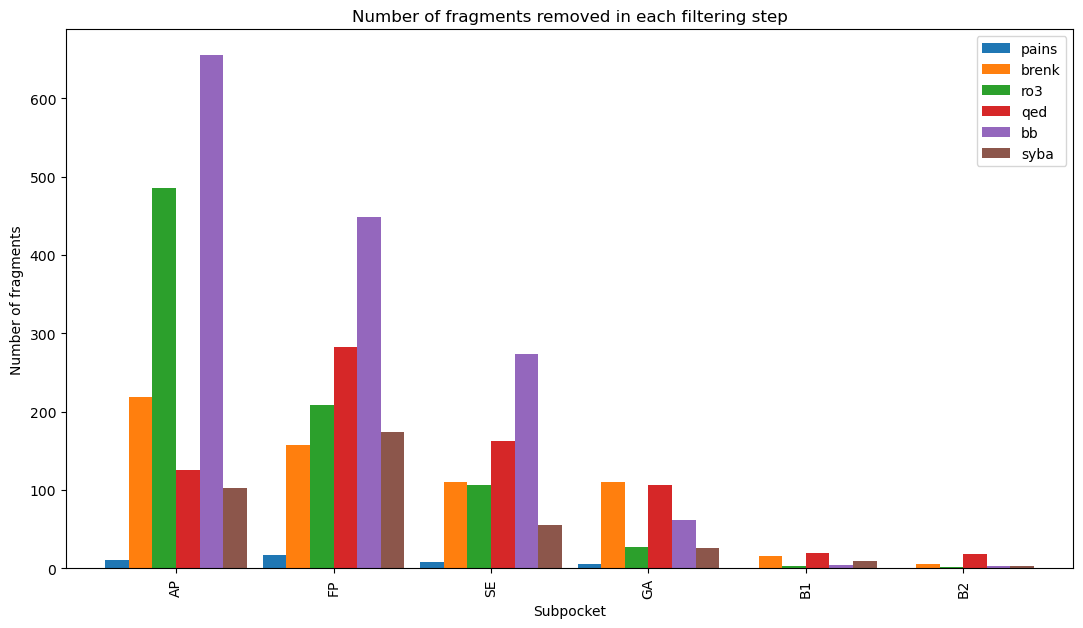

In [12]:
update_results = num_frags_development(filter_results)

In [13]:
def num_frags_total(filter_res):
    """
    Count the number of fragments passing each custom filter step

    ----------
    filter_res : dataframe
        Contains the calculated values and the boolean for each filtering step if a fragment was
        accepted or not.

    Returns
    ---------
    dataframe
        with the number of fragments per subpocket for each filtering step

    """
    # get the column names
    frag_keys = filter_res.keys()
    frag_keys.to_list()
    # keep only the boolean column names (we do not need the computed values here)
    bool_keys = [x for x in frag_keys if "bool" in x and "retro" not in x]
    # create a dataframe to store the number of fragments left after each filtering step
    update_results = pd.DataFrame()
    # add number of fragments for the pre-filtered subset we are starting with
    update_results["Pre-filtered"] = filter_res.reset_index().groupby(
        "subpocket", sort=False
    ).size()
    # go through all boolean columns and count the number of fragments passing
    for bool_key in bool_keys:
        filter_res = filter_res.loc[filter_res[bool_key] == 1]
    
    update_results["All filters"] = filter_res.reset_index().groupby("subpocket", sort=False).size()
    filter_res = filter_res.loc[filter_res['bool_retro'] == 1]
    update_results["Filters + retro"] = filter_res.reset_index().groupby("subpocket", sort=False).size()
    # create a bar plot showing the numbers of fragments passing
    ax = update_results.plot.bar(width=0.9)
    fig = ax.get_figure()

    fig.set_figheight(7)
    fig.set_figwidth(13)

    ax.set_xlabel("Subpocket")
    ax.set_ylabel("Number of fragments")
    ax.set_title("Total number of fragments remaining")
    plt.savefig(f"figures/n_fragments_filter_total.png", dpi=300, bbox_inches="tight")
    plt.show()
    # return dataframe with number of fragments after each filtering step.
    return update_results

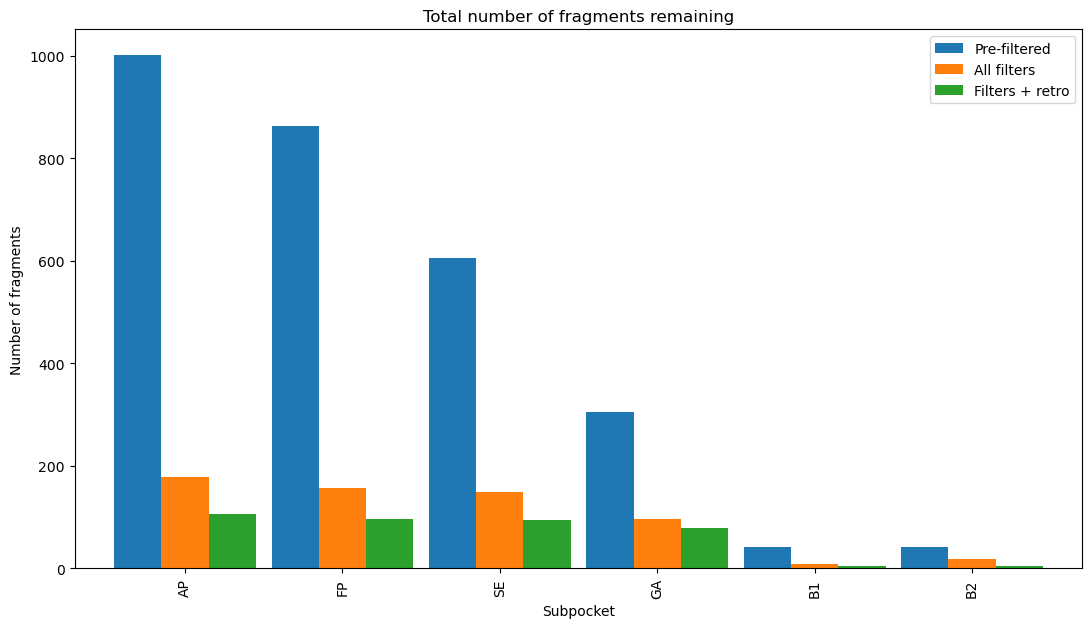

,Pre-filtered,All filters,Filters + retro
subpocket,,,
AP,1001,179,107
FP,862,156,97
SE,606,150,95
GA,306,96,79
B1,42,8,5
B2,42,18,5


In [14]:
num_frags_total(filter_results)

#### 1.3 KinFragLib update

**Download data**

Here we analyze the number of fragments in the old version of KinFragLib compared to the updated version, which contains a newer version of KLIFS data (from Nov. 2023). 
To run this part of the code, we need to download the old KinFragLib version from zenodo. Please follow the instructions given in `../data/fragment_library_old/README.md`.

In [10]:
fragment_library_old = utils.read_fragment_library(PATH_DATA / "fragment_library_old")
fragment_library_new = utils.read_fragment_library(PATH_DATA / "fragment_library")

In [28]:
SUBPOCKET_COLORS_X = {
    "AP": "purple",
    "FP": "forestgreen",
    "SE": "c",
    "GA": "tab:orange",
    "B1": "tab:blue",
    "B2": "darkslateblue",
    "X": "grey",
}

def plot_n_fragments_kinfraglib(
    n_fragments_per_subpocket_new, n_fragments_per_subpocket_old
):
    """
    Plot number of fragments and deduplicated fragments per subpocket.
    """
    plt.figure(figsize=(8, 8))
    ax1 = plt.bar(
        SUBPOCKET_COLORS_X.keys(),
        n_fragments_per_subpocket_new,
        fill=False,
        edgecolor=SUBPOCKET_COLORS_X.values(),
    )
    ax2 = plt.bar(
        SUBPOCKET_COLORS_X.keys(),
        n_fragments_per_subpocket_old,
        color=SUBPOCKET_COLORS_X.values(),
    )
    plt.legend(["Updated KinFragLib\nfragments", "Previous KinFragLib\nfragments"], fontsize=17)
    plt.ylabel("# Fragments", fontsize=17)
    plt.xlabel("Subpocket", fontsize=17)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    plt.savefig(f"figures/old_vs_new_kinfraglib.png", dpi=300, bbox_inches="tight")

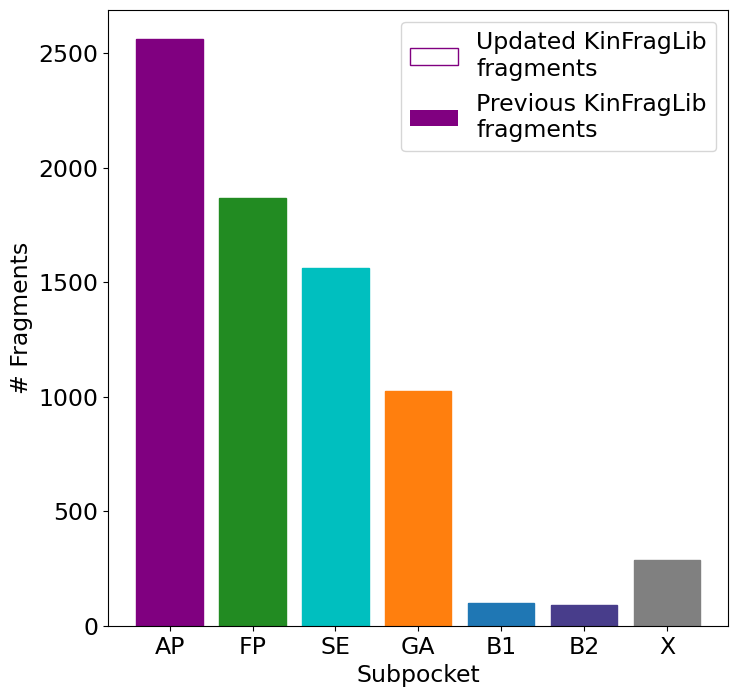

In [27]:
n_fragments_per_subpocket_new = [len(fragments) for _, fragments in fragment_library_new.items()]
n_fragments_per_subpocket_old = [len(fragments) for _, fragments in fragment_library_old.items()]
plot_n_fragments_kinfraglib(n_fragments_per_subpocket_new, n_fragments_per_subpocket_old)

### 2. Fragment space 

#### 2.1 t-SNE plot
t-SNE plot of pre-filtered KinFragLib with fragments colored in based on each filter respectively. 

In [15]:
def calc_tsne(fragment_library): 
    """
    Creates t-SNE embeddings of pre-filtered KinFragLib library.

    ----------
    fragment_library : dict
        fragment library organized in subpockets

    Returns
    ---------
    dataframe
        with the t-SNE embedding 
    """
    # calculate MACCS fingerprints for t-sne 
    fragment_library["ROMol"] = fragment_library.smiles.apply(Chem.MolFromSmiles)
    fragment_library["maccs"] = fragment_library.ROMol.apply(MACCSkeys.GenMACCSKeys)
    pca = PCA(n_components=50)
    crds = pca.fit_transform(list(fragment_library["maccs"]))
    crds_embedded = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=0).fit_transform(crds)
    tsne_df = pd.DataFrame(crds_embedded, columns=["X", "Y"])

    return tsne_df

In [16]:
def create_tsne_plots(fragment_library_concat, bool_filter, tsne_df):
    """
    Creates t-SNE plots comparing pre-filtered and custom filtered fragment library.

    ----------
    fragment_library : dict
        fragment library organized in subpockets containing boolean column 
         defining if the fragments are part of the subset (specified in bool_filter)
    bool_filter: str
        filter that should be used for coloring the fragments (should be a column in fragment_library_concat)
    tsne_df: dataframe
        contains the t-sne embedding of pre-filtered KinFragLib
    """

    tsne_df[bool_filter] = fragment_library_concat[bool_filter]

    sns.scatterplot(
        data=tsne_df.query(bool_filter + " == 0"),
        x="X",
        y="Y",
        color='lightcoral',
        alpha=0.5,
        label="excluded"
    ).set_title("pre-filtered vs. custom KinfragLib fragments")
    sns.scatterplot(
        data=tsne_df.query(bool_filter + " == 1"),
        x="X",
        y="Y",
        color='green',
        alpha=0.5,
        label="included"
    )

    plt.legend()
    plt.savefig(f"figures/tsne_" + bool_filter + ".png", dpi=300, bbox_inches="tight")
    plt.show()


In [17]:
# create bool_custom column indicating whether the fragment is in CustomKinFragLib or not
frag_keys = filter_results.keys()
frag_keys.to_list()
bool_keys = [x for x in frag_keys if "bool" in x]

# go through all boolean columns (filters)
bool_custom = pd.Series([True]*len(filter_results))
for bool_key in bool_keys:
    bool_custom = bool_custom & filter_results[bool_key] == 1
filter_results["bool_custom"] = bool_custom


In [18]:
# calculate t-SNE coordinates once only 
tsne_df = calc_tsne(filter_results)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f271ad899d0>
Traceback (most recent call last):
  File "/home/katharina/miniforge3/envs/kinfraglib/lib/python3.8/site-packages/threadpoolctl.py", line 847, in match_library_callback
    entry.
  File "/home/katharina/miniforge3/envs/kinfraglib/lib/python3.8/site-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    
  File "/home/katharina/miniforge3/envs/kinfraglib/lib/python3.8/site-packages/threadpoolctl.py", line 111, in __init__
    self.prefix = prefix
  File "/home/katharina/miniforge3/envs/kinfraglib/lib/python3.8/ctypes/__init__.py", line 373, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f271ad899d0>
Traceba

#### CustomKinFragLib t-SNE

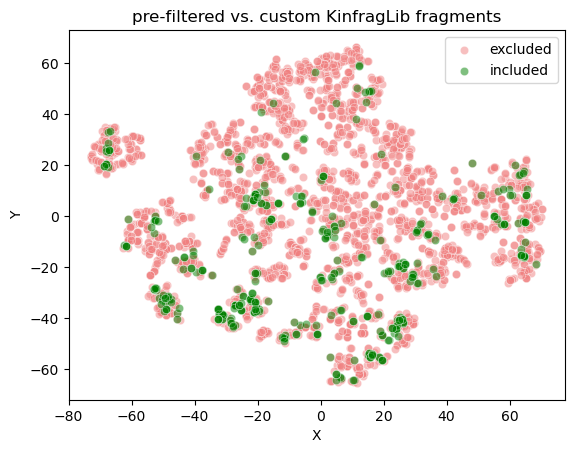

In [19]:
create_tsne_plots(filter_results, "bool_custom", tsne_df)

#### Ro3 t-SNE

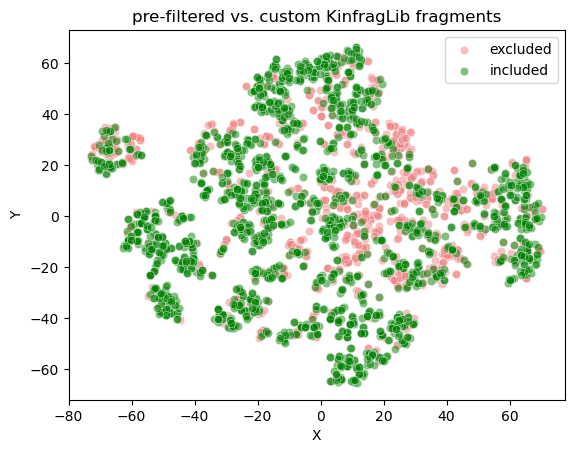

In [20]:
create_tsne_plots(filter_results, "bool_ro3", tsne_df)

#### Building block t-SNE

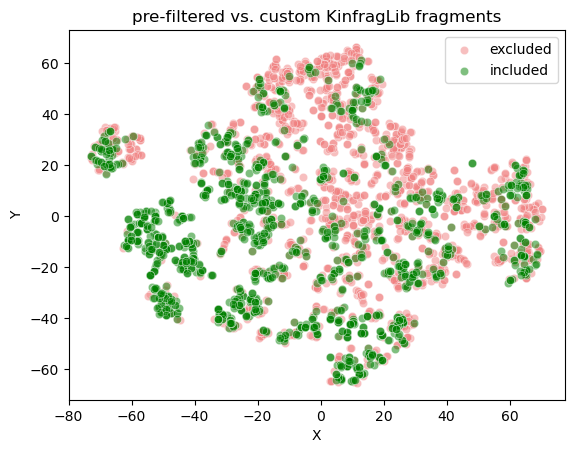

In [21]:
create_tsne_plots(filter_results, "bool_bb", tsne_df)

#### Brenk t-SNE

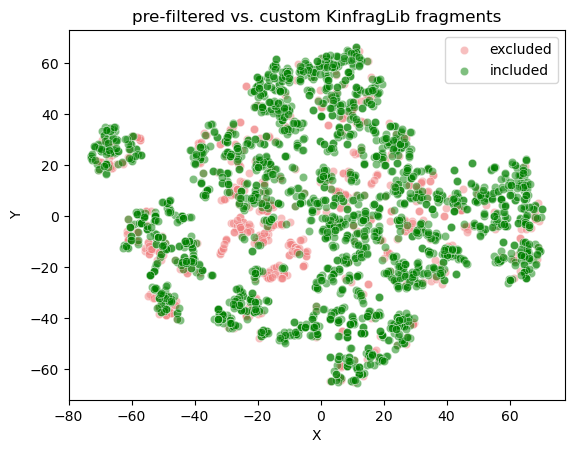

In [22]:
create_tsne_plots(filter_results, "bool_brenk", tsne_df)

#### QED t-SNE

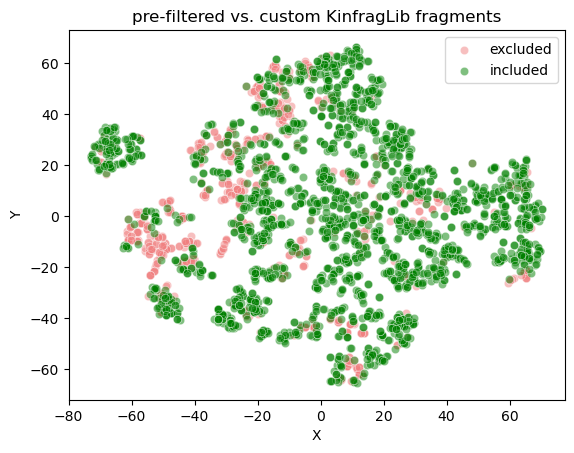

In [23]:
create_tsne_plots(filter_results, "bool_qed", tsne_df)

#### SYBA t-SNE

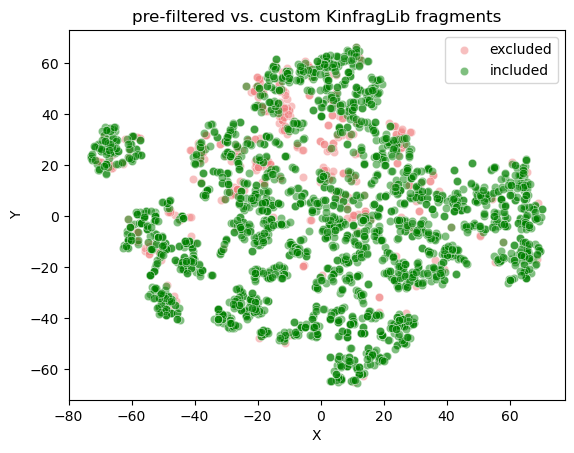

In [24]:
create_tsne_plots(filter_results, "bool_syba", tsne_df)

#### PAINS t-SNE

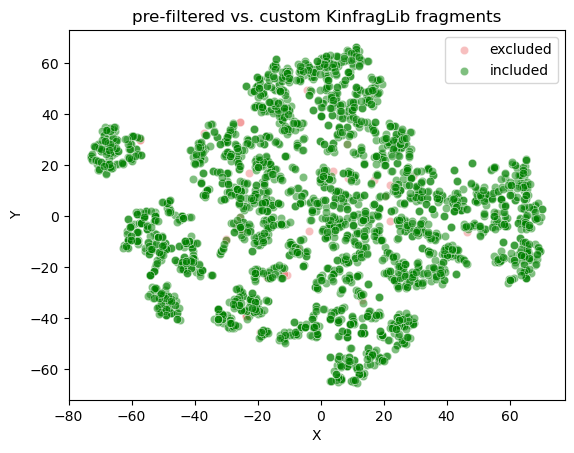

In [25]:
create_tsne_plots(filter_results, "bool_pains", tsne_df)

#### 2.2 Clustering
[Not used in the paper]

In [26]:
fragment_library_reduced = utils.read_fragment_library(PATH_DATA / "fragment_library_reduced")

In [27]:
smiles = pd.concat(fragment_library).smiles.tolist()
smiles_custom = pd.concat(fragment_library_custom).smiles.tolist()

In [28]:
clusters = utils.cluster_molecules(pd.concat(fragment_library).ROMol, cutoff=0.6)

Number of molecules: 2859
Threshold:  0.6
Number of clusters:  453
# Clusters with only 1 molecule:  198
# Clusters with more than 5 molecules:  105
# Clusters with more than 25 molecules:  24
# Clusters with more than 100 molecules:  4


In [29]:
cluster_indexes = []
for smi in smiles_custom: 
    ind = smiles.index(smi)
    cluster_id = clusters[clusters.molecule_id == ind].cluster_id
    cluster_indexes.append(int(cluster_id))


In [30]:
print(f"{len(set(cluster_indexes))} clusters out of {max(clusters.cluster_id)} clusters in total ({round(len(set(cluster_indexes))/max(clusters.cluster_id), 4) * 100} %) are covered in customKinFragLib")

84 clusters out of 453 clusters in total (18.54 %) are covered in customKinFragLib


In [31]:
covered_comps = sum(clusters.cluster_id.isin(cluster_indexes))
print(f"{covered_comps} out of {len(smiles)} compounds ({round(covered_comps/len(smiles) * 100, 2)}%) have a common cluster representative in customKinFragLib")

1644 out of 2859 compounds (57.5%) have a common cluster representative in customKinFragLib


In [32]:
cluster_counts = Counter(clusters.cluster_id)
custom_cluster_counts = [cluster_counts[c] for c in list(set(cluster_indexes))]
custom_counts = [0, 0, 0, 0, 0]
custom_counts[0] = sum([1 for count in custom_cluster_counts if count == 1])
custom_counts[1] = sum([1 for count in custom_cluster_counts if count > 1])
custom_counts[2] = sum([1 for count in custom_cluster_counts if count > 5])
custom_counts[3] = sum([1 for count in custom_cluster_counts if count > 25])
custom_counts[4] = sum([1 for count in custom_cluster_counts if count > 100])


In [33]:
fragment_counts = [0, 0, 0, 0, 0]
fragment_counts[0] = sum([1 for count in list(cluster_counts.values()) if count == 1])
fragment_counts[1] = sum([1 for count in list(cluster_counts.values()) if count > 1])
fragment_counts[2] = sum([1 for count in list(cluster_counts.values()) if count > 5])
fragment_counts[3] = sum([1 for count in list(cluster_counts.values()) if count > 25])
fragment_counts[4] = sum([1 for count in list(cluster_counts.values()) if count > 100])
#c_200 = sum([1 for count in list(cluster_counts.values()) if count > 100])

In [34]:
columns = ['1', '>1', '>5', '>25', '>100']
fraction = [c/f for (c, f) in zip(custom_counts, fragment_counts)]
df = pd.DataFrame(zip(columns, custom_counts, fragment_counts, fraction), columns=['Count', 'CustomKinFragLib', 'Pre-filtered fragment library', 'Coverage'])

In [35]:
print("Coverage per cluster size:")
df.round({'Coverage': 2})

Coverage per cluster size:


,Count,CustomKinFragLib,Pre-filtered fragment library,Coverage
0,1,9,198,0.05
1,>1,75,255,0.29
2,>5,55,105,0.52
3,>25,19,24,0.79
4,>100,4,4,1.00


#### 2.3 Average Tanimoto similarity 

In [36]:
def calc_avg_tanimoto_distance(molecules: list) -> float: # maybe add this to utils (?)
    """
    Returns the mean tanimoto distance of a given list of molecules.

    Returns
    -------
    Mean tanimoto distance of given molecules

    Parameters
    -----------
    molecules: list
        List of molecules (rdkit.Mol)
    """
    # Generate fingerprints
    fps = utils._generate_fingerprints(molecules)

    # Calculate Tanimoto distance matrix
    distance_matrix = utils._get_tanimoto_distance_matrix(fps)

    return np.mean(distance_matrix)

In [37]:
mols = pd.concat(fragment_library).ROMol.tolist()
mols_custom = pd.concat(fragment_library_custom).ROMol.tolist()


In [38]:
div = calc_avg_tanimoto_distance(mols)
div_custom = calc_avg_tanimoto_distance(mols_custom)
print(f'Diversity of pre-filtered KinFragLib: {round(div, 3)}')
print(f'Diversity of CustomKinFragLib: {round(div_custom, 3)}')

Diversity of pre-filtered KinFragLib: 0.907
Diversity of CustomKinFragLib: 0.859


##### 2.3.1 Average Tanimoto Similarity per Subpocket

In [43]:
print(f"Avg. diversity per subpocket:\n")
print(f"Subpocket\tPre-filtered KinFragLib\t\tCustomKinFragLib")
print(f"---------\t-----------------------\t\t----------------")
for subpocket in fragment_library:
    mols = fragment_library[subpocket].ROMol.tolist()
    mols_custom = fragment_library_custom[subpocket].ROMol.tolist()

    div = calc_avg_tanimoto_distance(mols)
    div_custom = calc_avg_tanimoto_distance(mols_custom)

    print(f"{subpocket}\t\t{div:.3f}\t\t\t\t{div_custom:.3f}")

Avg. diversity per subpocket:

Subpocket	Pre-filtered KinFragLib		CustomKinFragLib
---------	-----------------------		----------------
AP		0.859				0.839
FP		0.911				0.871
SE		0.897				0.856
GA		0.895				0.833
B1		0.926				0.857
B2		0.908				0.851


#### 2.4 Standadized Shannon Entropy of Murcko Scaffolds 

In [44]:
# add murcko scaffolds to fragment library 
for subpocket in fragment_library.keys():
    PandasTools.AddMurckoToFrame(fragment_library[subpocket])
    PandasTools.AddMurckoToFrame(fragment_library_custom[subpocket])

Some fragments do not contain any rings and hence have an empty murcko scafold. Since the number of these fragments is rather low, and we cannot make any assumption on them, we exclude them in the following entropy calculations. 

In [56]:
num_fragments = pd.concat(fragment_library).shape[0]
num_fragments_custom = pd.concat(fragment_library_custom).shape[0]

num_empty_scaffolds = sum((sum(fragments['Murcko_SMILES'] == "") for fragments in fragment_library.values()))
num_empty_scaffolds_custom = sum((sum(fragments['Murcko_SMILES'] == "") for fragments in fragment_library_custom.values()))

print(f"Total numer of pre-filtered KinFragLib fragments: {num_fragments}")
print(f"Number of pre-filtered KinFragLib fragments with empty scaffold: {num_empty_scaffolds} ({100 * num_empty_scaffolds/num_fragments:.1f}%)\n")

print(f"Total numer of CustomKinFragLib fragments: {num_fragments_custom}")
print(f"Number of CustomKinFragLib fragments with empty scaffold: {num_empty_scaffolds_custom} ({100 * num_empty_scaffolds_custom/num_fragments_custom:.1f}%)")

Total numer of pre-filtered KinFragLib fragments: 2859
Number of pre-filtered KinFragLib fragments with empty scaffold: 261 (9.1%)

Total numer of CustomKinFragLib fragments: 388
Number of CustomKinFragLib fragments with empty scaffold: 2 (0.5%)


In [71]:
def calc_sse(murcko_smiles: pd.Series) -> float:
    """
    Returns the scaled Shannon Entropy of a given list of Murcko scaffold.

    Returns
    -------
    Scaled Shannon Entropy of a given list of Murcko scaffold

    Parameters
    -----------
    molecules: Pandas.Series
        List of Murcko scaffolds as SMILES (str)
    """
    p = murcko_smiles.shape[0]

    unique_scaffolds = murcko_smiles.value_counts()

    se = - sum((scaffold_count/p) * math.log2(scaffold_count/p) for scaffold_count in unique_scaffolds)
    
    return se / math.log2(unique_scaffolds.shape[0])

In [76]:
murcko_smiles = pd.concat(fragment_library)[pd.concat(fragment_library)['Murcko_SMILES'] != ""]['Murcko_SMILES']
murcko_smiles_custom = pd.concat(fragment_library_custom)[pd.concat(fragment_library_custom)['Murcko_SMILES'] != ""]['Murcko_SMILES']

In [79]:
sse = calc_sse(murcko_smiles)
sse_custom = calc_sse(murcko_smiles_custom)
print(f'SSE of pre-filtered KinFragLib: {round(sse, 3)}')
print(f'SSE of CustomKinFragLib: {round(sse_custom, 3)}')

SSE of pre-filtered KinFragLib: 0.779
SSE of CustomKinFragLib: 0.671


In [74]:
print(f"SSE per subpocket:\n")
print(f"Subpocket\tPre-filtered KinFragLib\t\tCustomKinFragLib")
print(f"---------\t-----------------------\t\t----------------")
for subpocket in fragment_library:
    murcko_smiles = fragment_library[subpocket][fragment_library[subpocket]['Murcko_SMILES'] != ""]['Murcko_SMILES']
    murcko_smiles_custom = fragment_library_custom[subpocket][fragment_library_custom[subpocket]['Murcko_SMILES'] != ""]['Murcko_SMILES']

    sse = calc_sse(murcko_smiles)
    sse_custom = calc_sse(murcko_smiles_custom)

    print(f"{subpocket}\t\t{sse:.3f}\t\t\t\t{sse_custom:.3f}")

SSE per subpocket:

Subpocket	Pre-filtered KinFragLib		CustomKinFragLib
---------	-----------------------		----------------
AP		0.878				0.870
FP		0.812				0.728
SE		0.796				0.693
GA		0.653				0.601
B1		0.698				0.961
B2		0.764				0.865
